# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [0]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
from torch.optim import lr_scheduler
import os

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [0]:
learning_rate = 0.0001
batch_size_training = 128
batch_size_testing = 128
epoches = 25
filename = "./output"

if not os.path.exists(filename):
    os.makedirs(filename)

filename = "./data"

if not os.path.exists(filename):
    os.makedirs(filename)

filename = "./figures"

if not os.path.exists(filename):
    os.makedirs(filename)

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [0]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
import torchvision.transforms as transforms
from ipywidgets import IntProgress
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from torch.autograd import Variable

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [0]:
transform_training = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_testing = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [6]:
cifar_training = dset.CIFAR10(root="./data", train = True, transform = transform_training, download = True )
cifar_testing = dset.CIFAR10(root="./data", train = False, transform = transform_testing, download = True )

data_loader_training = data.DataLoader(dataset = cifar_training, batch_size=batch_size_training,)
data_loader_testing = data.DataLoader( dataset =cifar_testing, batch_size = batch_size_testing)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paepr below to understand the structure.
### https://arxiv.org/abs/1409.4842


------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [0]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
    
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True))

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True))

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True))

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True))

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

        

-----
### GoogLeNet Module (There exist many implement methods)

<img src="./Picture1.png" height="1000" width="10000">


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [0]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()

        self.pre_inception = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True))
        
        self.inception_block_1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.inception_block_2 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception_block_3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_block_4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_block_5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_block_6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception_block_7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inception_block_8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_block_9 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.average_pool = nn.AvgPool2d(8, stride=1)

        self.fully_connected_layer = nn.Linear(1024,10)

    def forward(self,x):
        output = self.pre_inception(x)
        output = self.inception_block_1(output)
        output = self.inception_block_2(output)
        output = self.max_pool(output)
        output = self.inception_block_3(output)
        output = self.inception_block_4(output)
        output = self.inception_block_5(output)
        output = self.inception_block_6(output)
        output = self.inception_block_7(output)
        output = self.max_pool(output)
        output = self.inception_block_8(output)
        output = self.inception_block_9(output)
        output = self.average_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fully_connected_layer(output)

        return output

### Next, we create the networka and send it to the target device

In [9]:
network = GoogLeNet()
network.to(device)

# if device == 'cuda':
#     network = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

GoogLeNet(
  (pre_inception): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inception_block_1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [0]:
def train_nn():
    network.train()
    accum_training_loss = 0
    total_data = 0
    correc_pred = 0
    for j, (image, label) in enumerate(data_loader_training):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = network(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        accum_training_loss += loss.data
        temp, prediction = torch.max(output.data,1)
        total_data += label.size(0)
        correc_pred += (prediction == label).sum()
    scheduler.step()

    return accum_training_loss, total_data, correc_pred


In [0]:
def test_nn():
    network.eval()
    accum_training_loss = 0
    total_data = 0
    correc_pred = 0
    with torch.no_grad():            
        for j, (image, label) in enumerate(data_loader_testing):
            image = image.to(device)
            label = label.to(device)
            output = network(image)
            loss = criterion(output, label)
            accum_training_loss += loss.data
            temp, prediction = torch.max(output.data,1)
            total_data += label.size(0)
            correc_pred += (prediction == label).sum()

    return accum_training_loss, total_data, correc_pred


In [13]:
test_accuracy_list, train_accuracy_list, accum_training_loss_test_list, accum_training_loss_train_list,learning_rate_list = [], [], [], [], []

best_accuracy = 0

for i in range(epoches):
    
    print("Epoch {} | Learning Rate {}".format(i, optimizer.param_groups[0]['lr']))

    accum_training_loss_train, total_data_train, correc_pred_train = train_nn()
    accum_training_loss_test, total_data_test, correc_pred_test = test_nn()

    test_accuracy = (correc_pred_test.item()/total_data_test)*100
    train_accuracy = (correc_pred_train.item()/total_data_train)*100

    print("\tTrain Accuracy {}, Test Accuracy {}".format(train_accuracy, test_accuracy),end="")
    print(", Train Loss {}, Test Loss {}" .format(accum_training_loss_train, accum_training_loss_test))

    if test_accuracy > best_accuracy:
        
        state = {
            'net': network.state_dict(),
            'epoch': i,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'train loss': accum_training_loss_train,
            'test loss': accum_training_loss_test
        }
        torch.save(state, './output/output.pt')

    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)
    accum_training_loss_test_list.append(accum_training_loss_test)
    accum_training_loss_train_list.append(accum_training_loss_train)
    learning_rate_list.append(optimizer.param_groups[0]['lr'])


Epoch 0 | Learning Rate 0.0001
	Train Accuracy 54.02400000000001, Test Accuracy 63.75999999999999, Train Loss 499.54083251953125, Test Loss 80.78498077392578
Epoch 1 | Learning Rate 0.0001
	Train Accuracy 70.658, Test Accuracy 72.95, Train Loss 325.8468933105469, Test Loss 62.8060302734375
Epoch 2 | Learning Rate 0.0001
	Train Accuracy 77.99000000000001, Test Accuracy 77.4, Train Loss 248.5711669921875, Test Loss 53.15684127807617
Epoch 3 | Learning Rate 0.0001
	Train Accuracy 82.646, Test Accuracy 80.99, Train Loss 198.86416625976562, Test Loss 44.68674850463867
Epoch 4 | Learning Rate 0.0001
	Train Accuracy 85.33800000000001, Test Accuracy 81.38, Train Loss 168.89962768554688, Test Loss 43.61044692993164
Epoch 5 | Learning Rate 0.0001
	Train Accuracy 87.484, Test Accuracy 83.94, Train Loss 144.39846801757812, Test Loss 40.017173767089844
Epoch 6 | Learning Rate 0.0001
	Train Accuracy 89.134, Test Accuracy 82.84, Train Loss 123.42965698242188, Test Loss 41.83345031738281
Epoch 7 | Lea

## Graphing Results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


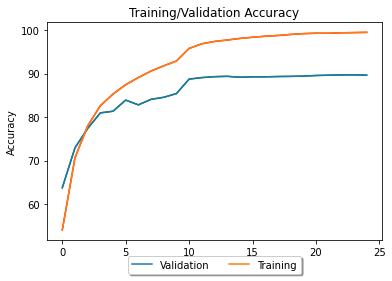

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


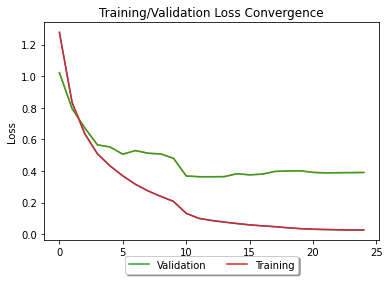

<Figure size 432x288 with 0 Axes>

In [31]:
x = [i for i in range(25)]
import matplotlib.pyplot as plt

plt.plot(x,test_accuracy_list,"g")
plt.plot(x,train_accuracy_list,"r")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training/Validation Accuracy")
ax = plt.subplot(111)
ax.plot(x, test_accuracy_list, label = "Validation")
ax.plot(x, train_accuracy_list, label= "Training")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()
plt.savefig('./figures/accuracyFig.png')

train_loss_list = [x / len(data_loader_training) for x in accum_training_loss_train_list]
test_loss_list = [x / len(data_loader_testing) for x in accum_training_loss_test_list]

plt.plot(x,train_loss_list)
plt.plot(x,test_loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training/Validation Loss Convergence")
ax = plt.subplot(111)
ax.plot(x, test_loss_list, label = "Validation")
ax.plot(x, train_loss_list, label= "Training")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()
plt.savefig('./figures/lossFig.png')



## Tabling Results

In [32]:
train_loss_table = []
test_loss_table = []
for i in range(len(accum_training_loss_train_list)):
    train_loss_table.append(accum_training_loss_train_list[i].item())
for i in range(len(accum_training_loss_test_list)):
    test_loss_table.append(accum_training_loss_test_list[i].item())

df = pd.DataFrame({"Epoch": x, "Learn Rate": learning_rate_list,"Train Loss":train_loss_table, "Test Loss":test_loss_table, "Train Acc.":train_accuracy_list, "Test Acc.": test_accuracy_list})
df


,Epoch,Learn Rate,Train Loss,Test Loss,Train Acc.,Test Acc.
0,0,0.000100,499.540833,80.784981,54.024,63.76
1,1,0.000100,325.846893,62.806030,70.658,72.95
2,2,0.000100,248.571167,53.156841,77.990,77.40
3,3,0.000100,198.864166,44.686749,82.646,80.99
4,4,0.000100,168.899628,43.610447,85.338,81.38
5,5,0.000100,144.398468,40.017174,87.484,83.94
6,6,0.000100,123.429657,41.833450,89.134,82.84
7,7,0.000100,107.012253,40.491074,90.632,84.11
8,8,0.000100,93.554314,40.149582,91.830,84.58
9,9,0.000010,81.181938,37.948967,92.932,85.44


## Model Parameters

In [42]:
model = torch.load('./output/output.pt')

print("Number of Iterations:", model["epoch"])
print("Training Accuracy:", model["train accuracy"])
print("Testing Accuracy:", model["test accuracy"])
print("Training Loss:", model["train loss"].item())
print("Testing Loss:", model["test loss"].item())

Number of Iterations: 24
Training Accuracy: 99.528
Testing Accuracy: 89.68
Training Loss: 10.487438201904297
Testing Loss: tensor(30.8849, device='cuda:0')


In [43]:
print("Model", model["net"])

Streaming output truncated to the last 5000 lines.
         ...,

         [[-0.0064]],

         [[-0.0025]],

         [[-0.0204]]],


        [[[-0.0364]],

         [[-0.0293]],

         [[ 0.0397]],

         ...,

         [[-0.0427]],

         [[ 0.0139]],

         [[ 0.0163]]],


        [[[ 0.0080]],

         [[-0.0056]],

         [[-0.0015]],

         ...,

         [[ 0.0329]],

         [[-0.0407]],

         [[ 0.0285]]],


        ...,


        [[[ 0.0165]],

         [[-0.0252]],

         [[ 0.0147]],

         ...,

         [[-0.0292]],

         [[-0.0148]],

         [[ 0.0078]]],


        [[[-0.0035]],

         [[-0.0072]],

         [[-0.0092]],

         ...,

         [[-0.0314]],

         [[-0.0044]],

         [[-0.0361]]],


        [[[-0.0441]],

         [[-0.0433]],

         [[-0.0331]],

         ...,

         [[-0.0145]],

         [[-0.0031]],

         [[-0.0203]]]], device='cuda:0')), ('inception_block_7.b1.0.bias', tensor([-9.3877e-03,  2